## Importing libraries

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, optimizers, Input
from PIL import Image, ImageOps
import random

## Setting seed

In [2]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [3]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [4]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [5]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [6]:
input_tensor = Input(shape=(224, 224, 3))

base_model = EfficientNetB7(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-3]:
    layer.trainable = False

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [7]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 178s 10s/step - loss: 24174.1719 - mae: 123.8549 - val_loss: 17752.3574 - val_mae: 96.1507
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 9s/step - loss: 17200.4258 - mae: 94.7649 - val_loss: 10725.3662 - val_mae: 65.9389
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - loss: 10209.5469 - mae: 71.0743 - val_loss: 6941.0869 - val_mae: 59.6599
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - loss: 7350.9902 - mae: 65.3847 - val_loss: 6163.9824 - val_mae: 57.4205
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 108s 9s/step - loss: 6730.2119 - mae: 61.5019 - val_loss: 5684.1338 - val_mae: 50.3925
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 109s 9s/step - loss: 5712.0659 - mae: 55.5319 - val_loss: 5266.1230 - val_mae: 45.7724
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - loss: 5168.4912 - mae: 51.7353 - val_loss: 4823.2358 - val_mae: 42.5060
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - loss: 5156.9189 - mae: 50.3723 - val_loss: 4340.6787 - val_mae: 4

## Training curves visualisation

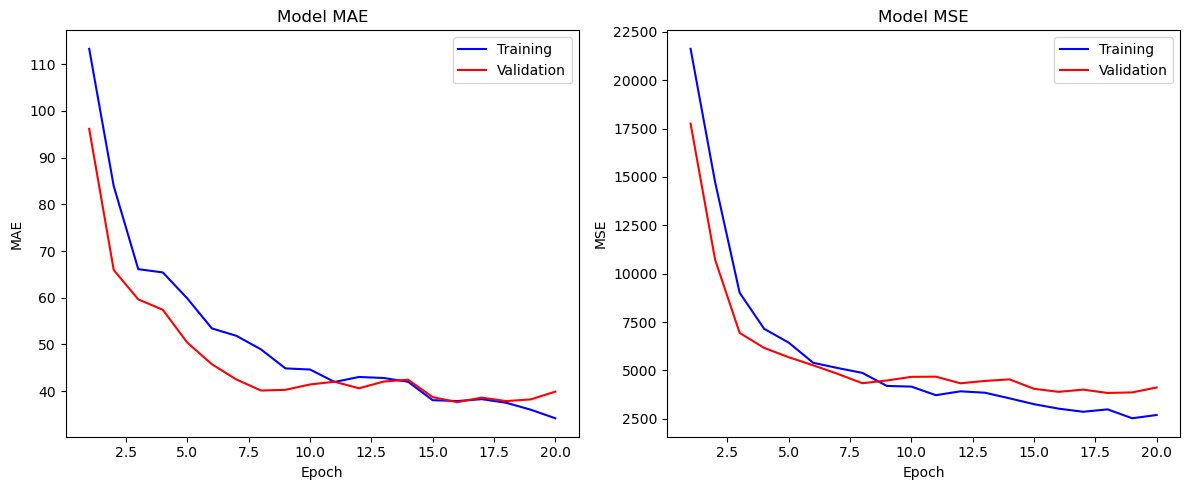

In [8]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [9]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step  


'input_layer', 'rescaling', 'normalization', 'rescaling_1', 'stem_conv_pad', 'stem_conv', 'stem_bn', 'stem_activation', 'block1a_dwconv', 'block1a_bn', 'block1a_activation', 'block1a_se_squeeze', 'block1a_se_reshape', 'block1a_se_reduce', 'block1a_se_expand', 'block1a_se_excite', 'block1a_project_conv', 'block1a_project_bn', 'block1b_dwconv', 'block1b_bn', 'block1b_activation', 'block1b_se_squeeze', 'block1b_se_reshape', 'block1b_se_reduce', 'block1b_se_expand', 'block1b_se_excite', 'block1b_project_conv', 'block1b_project_bn', 'block1b_drop', 'block1b_add', 'block1c_dwconv', 'block1c_bn', 'block1c_activation', 'block1c_se_squeeze', 'block1c_se_reshape', 'block1c_se_reduce', 'block1c_se_expand', 'block1c_se_excite', 'block1c_project_conv', 'block1c_project_bn', 'block1c_drop', 'block1c_add', 'block1d_dwconv', 'block1d_bn', 'block1d_activation', 'block1d_se_squeeze', 'block1d_se_reshape', 'block1d_se_reduce', 'block1d_se_expand', 'block1d_se_excite', 'block1d_project_conv', 'block1d_project_bn', 'block1d_drop', 'block1d_add', 'block2a_expand_conv', 'block2a_expand_bn', 'block2a_expand_activation', 'block2a_dwconv_pad', 'block2a_dwconv', 'block2a_bn', 'block2a_activation', 'block2a_se_squeeze', 'block2a_se_reshape', 'block2a_se_reduce', 'block2a_se_expand', 'block2a_se_excite', 'block2a_project_conv', 'block2a_project_bn', 'block2b_expand_conv', 'block2b_expand_bn', 'block2b_expand_activation', 'block2b_dwconv', 'block2b_bn', 'block2b_activation', 'block2b_se_squeeze', 'block2b_se_reshape', 'block2b_se_reduce', 'block2b_se_expand', 'block2b_se_excite', 'block2b_project_conv', 'block2b_project_bn', 'block2b_drop', 'block2b_add', 'block2c_expand_conv', 'block2c_expand_bn', 'block2c_expand_activation', 'block2c_dwconv', 'block2c_bn', 'block2c_activation', 'block2c_se_squeeze', 'block2c_se_reshape', 'block2c_se_reduce', 'block2c_se_expand', 'block2c_se_excite', 'block2c_project_conv', 'block2c_project_bn', 'block2c_drop', 'block2c_add', 'block2d_expand_conv', 'block2d_expand_bn', 'block2d_expand_activation', 'block2d_dwconv', 'block2d_bn', 'block2d_activation', 'block2d_se_squeeze', 'block2d_se_reshape', 'block2d_se_reduce', 'block2d_se_expand', 'block2d_se_excite', 'block2d_project_conv', 'block2d_project_bn', 'block2d_drop', 'block2d_add', 'block2e_expand_conv', 'block2e_expand_bn', 'block2e_expand_activation', 'block2e_dwconv', 'block2e_bn', 'block2e_activation', 'block2e_se_squeeze', 'block2e_se_reshape', 'block2e_se_reduce', 'block2e_se_expand', 'block2e_se_excite', 'block2e_project_conv', 'block2e_project_bn', 'block2e_drop', 'block2e_add', 'block2f_expand_conv', 'block2f_expand_bn', 'block2f_expand_activation', 'block2f_dwconv', 'block2f_bn', 'block2f_activation', 'block2f_se_squeeze', 'block2f_se_reshape', 'block2f_se_reduce', 'block2f_se_expand', 'block2f_se_excite', 'block2f_project_conv', 'block2f_project_bn', 'block2f_drop', 'block2f_add', 'block2g_expand_conv', 'block2g_expand_bn', 'block2g_expand_activation', 'block2g_dwconv', 'block2g_bn', 'block2g_activation', 'block2g_se_squeeze', 'block2g_se_reshape', 'block2g_se_reduce', 'block2g_se_expand', 'block2g_se_excite', 'block2g_project_conv', 'block2g_project_bn', 'block2g_drop', 'block2g_add', 'block3a_expand_conv', 'block3a_expand_bn', 'block3a_expand_activation', 'block3a_dwconv_pad', 'block3a_dwconv', 'block3a_bn', 'block3a_activation', 'block3a_se_squeeze', 'block3a_se_reshape', 'block3a_se_reduce', 'block3a_se_expand', 'block3a_se_excite', 'block3a_project_conv', 'block3a_project_bn', 'block3b_expand_conv', 'block3b_expand_bn', 'block3b_expand_activation', 'block3b_dwconv', 'block3b_bn', 'block3b_activation', 'block3b_se_squeeze', 'block3b_se_reshape', 'block3b_se_reduce', 'block3b_se_expand', 'block3b_se_excite', 'block3b_project_conv', 'block3b_project_bn', 'block3b_drop', 'block3b_add', 'block3c_expand_conv', 'block3c_expand_bn', 'block3c_expand_activation', 'block3c_dwconv', 'block3c_bn', 'block3c_activation', 'block3c_se_squeeze', 'block3c_se_reshape', 'block3c_se_reduce', 'block3c_se_expand', 'block3c_se_excite', 'block3c_project_conv', 'block3c_project_bn', 'block3c_drop', 'block3c_add', 'block3d_expand_conv', 'block3d_expand_bn', 'block3d_expand_activation', 'block3d_dwconv', 'block3d_bn', 'block3d_activation', 'block3d_se_squeeze', 'block3d_se_reshape', 'block3d_se_reduce', 'block3d_se_expand', 'block3d_se_excite', 'block3d_project_conv', 'block3d_project_bn', 'block3d_drop', 'block3d_add', 'block3e_expand_conv', 'block3e_expand_bn', 'block3e_expand_activation', 'block3e_dwconv', 'block3e_bn', 'block3e_activation', 'block3e_se_squeeze', 'block3e_se_reshape', 'block3e_se_reduce', 'block3e_se_expand', 'block3e_se_excite', 'block3e_project_conv', 'block3e_project_bn', 'block3e_drop', 'block3e_add', 'block3f_expand_conv', 'block3f_expand_bn', 'block3f_expand_activation', 'block3f_dwconv', 'block3f_bn', 'block3f_activation', 'block3f_se_squeeze', 'block3f_se_reshape', 'block3f_se_reduce', 'block3f_se_expand', 'block3f_se_excite', 'block3f_project_conv', 'block3f_project_bn', 'block3f_drop', 'block3f_add', 'block3g_expand_conv', 'block3g_expand_bn', 'block3g_expand_activation', 'block3g_dwconv', 'block3g_bn', 'block3g_activation', 'block3g_se_squeeze', 'block3g_se_reshape', 'block3g_se_reduce', 'block3g_se_expand', 'block3g_se_excite', 'block3g_project_conv', 'block3g_project_bn', 'block3g_drop', 'block3g_add', 'block4a_expand_conv', 'block4a_expand_bn', 'block4a_expand_activation', 'block4a_dwconv_pad', 'block4a_dwconv', 'block4a_bn', 'block4a_activation', 'block4a_se_squeeze', 'block4a_se_reshape', 'block4a_se_reduce', 'block4a_se_expand', 'block4a_se_excite', 'block4a_project_conv', 'block4a_project_bn', 'block4b_expand_conv', 'block4b_expand_bn', 'block4b_expand_activation', 'block4b_dwconv', 'block4b_bn', 'block4b_activation', 'block4b_se_squeeze', 'block4b_se_reshape', 'block4b_se_reduce', 'block4b_se_expand', 'block4b_se_excite', 'block4b_project_conv', 'block4b_project_bn', 'block4b_drop', 'block4b_add', 'block4c_expand_conv', 'block4c_expand_bn', 'block4c_expand_activation', 'block4c_dwconv', 'block4c_bn', 'block4c_activation', 'block4c_se_squeeze', 'block4c_se_reshape', 'block4c_se_reduce', 'block4c_se_expand', 'block4c_se_excite', 'block4c_project_conv', 'block4c_project_bn', 'block4c_drop', 'block4c_add', 'block4d_expand_conv', 'block4d_expand_bn', 'block4d_expand_activation', 'block4d_dwconv', 'block4d_bn', 'block4d_activation', 'block4d_se_squeeze', 'block4d_se_reshape', 'block4d_se_reduce', 'block4d_se_expand', 'block4d_se_excite', 'block4d_project_conv', 'block4d_project_bn', 'block4d_drop', 'block4d_add', 'block4e_expand_conv', 'block4e_expand_bn', 'block4e_expand_activation', 'block4e_dwconv', 'block4e_bn', 'block4e_activation', 'block4e_se_squeeze', 'block4e_se_reshape', 'block4e_se_reduce', 'block4e_se_expand', 'block4e_se_excite', 'block4e_project_conv', 'block4e_project_bn', 'block4e_drop', 'block4e_add', 'block4f_expand_conv', 'block4f_expand_bn', 'block4f_expand_activation', 'block4f_dwconv', 'block4f_bn', 'block4f_activation', 'block4f_se_squeeze', 'block4f_se_reshape', 'block4f_se_reduce', 'block4f_se_expand', 'block4f_se_excite', 'block4f_project_conv', 'block4f_project_bn', 'block4f_drop', 'block4f_add', 'block4g_expand_conv', 'block4g_expand_bn', 'block4g_expand_activation', 'block4g_dwconv', 'block4g_bn', 'block4g_activation', 'block4g_se_squeeze', 'block4g_se_reshape', 'block4g_se_reduce', 'block4g_se_expand', 'block4g_se_excite', 'block4g_project_conv', 'block4g_project_bn', 'block4g_drop', 'block4g_add', 'block4h_expand_conv', 'block4h_expand_bn', 'block4h_expand_activation', 'block4h_dwconv', 'block4h_bn', 'block4h_activation', 'block4h_se_squeeze', 'block4h_se_reshape', 'block4h_se_reduce', 'block4h_se_expand', 'block4h_se_excite', 'block4h_project_conv', 'block4h_project_bn', 'block4h_drop', 'block4h_add', 'block4i_expand_conv', 'block4i_expand_bn', 'block4i_expand_activation', 'block4i_dwconv', 'block4i_bn', 'block4i_activation', 'block4i_se_squeeze', 'block4i_se_reshape', 'block4i_se_reduce', 'block4i_se_expand', 'block4i_se_excite', 'block4i_project_conv', 'block4i_project_bn', 'block4i_drop', 'block4i_add', 'block4j_expand_conv', 'block4j_expand_bn', 'block4j_expand_activation', 'block4j_dwconv', 'block4j_bn', 'block4j_activation', 'block4j_se_squeeze', 'block4j_se_reshape', 'block4j_se_reduce', 'block4j_se_expand', 'block4j_se_excite', 'block4j_project_conv', 'block4j_project_bn', 'block4j_drop', 'block4j_add', 'block5a_expand_conv', 'block5a_expand_bn', 'block5a_expand_activation', 'block5a_dwconv', 'block5a_bn', 'block5a_activation', 'block5a_se_squeeze', 'block5a_se_reshape', 'block5a_se_reduce', 'block5a_se_expand', 'block5a_se_excite', 'block5a_project_conv', 'block5a_project_bn', 'block5b_expand_conv', 'block5b_expand_bn', 'block5b_expand_activation', 'block5b_dwconv', 'block5b_bn', 'block5b_activation', 'block5b_se_squeeze', 'block5b_se_reshape', 'block5b_se_reduce', 'block5b_se_expand', 'block5b_se_excite', 'block5b_project_conv', 'block5b_project_bn', 'block5b_drop', 'block5b_add', 'block5c_expand_conv', 'block5c_expand_bn', 'block5c_expand_activation', 'block5c_dwconv', 'block5c_bn', 'block5c_activation', 'block5c_se_squeeze', 'block5c_se_reshape', 'block5c_se_reduce', 'block5c_se_expand', 'block5c_se_excite', 'block5c_project_conv', 'block5c_project_bn', 'block5c_drop', 'block5c_add', 'block5d_expand_conv', 'block5d_expand_bn', 'block5d_expand_activation', 'block5d_dwconv', 'block5d_bn', 'block5d_activation', 'block5d_se_squeeze', 'block5d_se_reshape', 'block5d_se_reduce', 'block5d_se_expand', 'block5d_se_excite', 'block5d_project_conv', 'block5d_project_bn', 'block5d_drop', 'block5d_add', 'block5e_expand_conv', 'block5e_expand_bn', 'block5e_expand_activation', 'block5e_dwconv', 'block5e_bn', 'block5e_activation', 'block5e_se_squeeze', 'block5e_se_reshape', 'block5e_se_reduce', 'block5e_se_expand', 'block5e_se_excite', 'block5e_project_conv', 'block5e_project_bn', 'block5e_drop', 'block5e_add', 'block5f_expand_conv', 'block5f_expand_bn', 'block5f_expand_activation', 'block5f_dwconv', 'block5f_bn', 'block5f_activation', 'block5f_se_squeeze', 'block5f_se_reshape', 'block5f_se_reduce', 'block5f_se_expand', 'block5f_se_excite', 'block5f_project_conv', 'block5f_project_bn', 'block5f_drop', 'block5f_add', 'block5g_expand_conv', 'block5g_expand_bn', 'block5g_expand_activation', 'block5g_dwconv', 'block5g_bn', 'block5g_activation', 'block5g_se_squeeze', 'block5g_se_reshape', 'block5g_se_reduce', 'block5g_se_expand', 'block5g_se_excite', 'block5g_project_conv', 'block5g_project_bn', 'block5g_drop', 'block5g_add', 'block5h_expand_conv', 'block5h_expand_bn', 'block5h_expand_activation', 'block5h_dwconv', 'block5h_bn', 'block5h_activation', 'block5h_se_squeeze', 'block5h_se_reshape', 'block5h_se_reduce', 'block5h_se_expand', 'block5h_se_excite', 'block5h_project_conv', 'block5h_project_bn', 'block5h_drop', 'block5h_add', 'block5i_expand_conv', 'block5i_expand_bn', 'block5i_expand_activation', 'block5i_dwconv', 'block5i_bn', 'block5i_activation', 'block5i_se_squeeze', 'block5i_se_reshape', 'block5i_se_reduce', 'block5i_se_expand', 'block5i_se_excite', 'block5i_project_conv', 'block5i_project_bn', 'block5i_drop', 'block5i_add', 'block5j_expand_conv', 'block5j_expand_bn', 'block5j_expand_activation', 'block5j_dwconv', 'block5j_bn', 'block5j_activation', 'block5j_se_squeeze', 'block5j_se_reshape', 'block5j_se_reduce', 'block5j_se_expand', 'block5j_se_excite', 'block5j_project_conv', 'block5j_project_bn', 'block5j_drop', 'block5j_add', 'block6a_expand_conv', 'block6a_expand_bn', 'block6a_expand_activation', 'block6a_dwconv_pad', 'block6a_dwconv', 'block6a_bn', 'block6a_activation', 'block6a_se_squeeze', 'block6a_se_reshape', 'block6a_se_reduce', 'block6a_se_expand', 'block6a_se_excite', 'block6a_project_conv', 'block6a_project_bn', 'block6b_expand_conv', 'block6b_expand_bn', 'block6b_expand_activation', 'block6b_dwconv', 'block6b_bn', 'block6b_activation', 'block6b_se_squeeze', 'block6b_se_reshape', 'block6b_se_reduce', 'block6b_se_expand', 'block6b_se_excite', 'block6b_project_conv', 'block6b_project_bn', 'block6b_drop', 'block6b_add', 'block6c_expand_conv', 'block6c_expand_bn', 'block6c_expand_activation', 'block6c_dwconv', 'block6c_bn', 'block6c_activation', 'block6c_se_squeeze', 'block6c_se_reshape', 'block6c_se_reduce', 'block6c_se_expand', 'block6c_se_excite', 'block6c_project_conv', 'block6c_project_bn', 'block6c_drop', 'block6c_add', 'block6d_expand_conv', 'block6d_expand_bn', 'block6d_expand_activation', 'block6d_dwconv', 'block6d_bn', 'block6d_activation', 'block6d_se_squeeze', 'block6d_se_reshape', 'block6d_se_reduce', 'block6d_se_expand', 'block6d_se_excite', 'block6d_project_conv', 'block6d_project_bn', 'block6d_drop', 'block6d_add', 'block6e_expand_conv', 'block6e_expand_bn', 'block6e_expand_activation', 'block6e_dwconv', 'block6e_bn', 'block6e_activation', 'block6e_se_squeeze', 'block6e_se_reshape', 'block6e_se_reduce', 'block6e_se_expand', 'block6e_se_excite', 'block6e_project_conv', 'block6e_project_bn', 'block6e_drop', 'block6e_add', 'block6f_expand_conv', 'block6f_expand_bn', 'block6f_expand_activation', 'block6f_dwconv', 'block6f_bn', 'block6f_activation', 'block6f_se_squeeze', 'block6f_se_reshape', 'block6f_se_reduce', 'block6f_se_expand', 'block6f_se_excite', 'block6f_project_conv', 'block6f_project_bn', 'block6f_drop', 'block6f_add', 'block6g_expand_conv', 'block6g_expand_bn', 'block6g_expand_activation', 'block6g_dwconv', 'block6g_bn', 'block6g_activation', 'block6g_se_squeeze', 'block6g_se_reshape', 'block6g_se_reduce', 'block6g_se_expand', 'block6g_se_excite', 'block6g_project_conv', 'block6g_project_bn', 'block6g_drop', 'block6g_add', 'block6h_expand_conv', 'block6h_expand_bn', 'block6h_expand_activation', 'block6h_dwconv', 'block6h_bn', 'block6h_activation', 'block6h_se_squeeze', 'block6h_se_reshape', 'block6h_se_reduce', 'block6h_se_expand', 'block6h_se_excite', 'block6h_project_conv', 'block6h_project_bn', 'block6h_drop', 'block6h_add', 'block6i_expand_conv', 'block6i_expand_bn', 'block6i_expand_activation', 'block6i_dwconv', 'block6i_bn', 'block6i_activation', 'block6i_se_squeeze', 'block6i_se_reshape', 'block6i_se_reduce', 'block6i_se_expand', 'block6i_se_excite', 'block6i_project_conv', 'block6i_project_bn', 'block6i_drop', 'block6i_add', 'block6j_expand_conv', 'block6j_expand_bn', 'block6j_expand_activation', 'block6j_dwconv', 'block6j_bn', 'block6j_activation', 'block6j_se_squeeze', 'block6j_se_reshape', 'block6j_se_reduce', 'block6j_se_expand', 'block6j_se_excite', 'block6j_project_conv', 'block6j_project_bn', 'block6j_drop', 'block6j_add', 'block6k_expand_conv', 'block6k_expand_bn', 'block6k_expand_activation', 'block6k_dwconv', 'block6k_bn', 'block6k_activation', 'block6k_se_squeeze', 'block6k_se_reshape', 'block6k_se_reduce', 'block6k_se_expand', 'block6k_se_excite', 'block6k_project_conv', 'block6k_project_bn', 'block6k_drop', 'block6k_add', 'block6l_expand_conv', 'block6l_expand_bn', 'block6l_expand_activation', 'block6l_dwconv', 'block6l_bn', 'block6l_activation', 'block6l_se_squeeze', 'block6l_se_reshape', 'block6l_se_reduce', 'block6l_se_expand', 'block6l_se_excite', 'block6l_project_conv', 'block6l_project_bn', 'block6l_drop', 'block6l_add', 'block6m_expand_conv', 'block6m_expand_bn', 'block6m_expand_activation', 'block6m_dwconv', 'block6m_bn', 'block6m_activation', 'block6m_se_squeeze', 'block6m_se_reshape', 'block6m_se_reduce', 'block6m_se_expand', 'block6m_se_excite', 'block6m_project_conv', 'block6m_project_bn', 'block6m_drop', 'block6m_add', 'block7a_expand_conv', 'block7a_expand_bn', 'block7a_expand_activation', 'block7a_dwconv', 'block7a_bn', 'block7a_activation', 'block7a_se_squeeze', 'block7a_se_reshape', 'block7a_se_reduce', 'block7a_se_expand', 'block7a_se_excite', 'block7a_project_conv', 'block7a_project_bn', 'block7b_expand_conv', 'block7b_expand_bn', 'block7b_expand_activation', 'block7b_dwconv', 'block7b_bn', 'block7b_activation', 'block7b_se_squeeze', 'block7b_se_reshape', 'block7b_se_reduce', 'block7b_se_expand', 'block7b_se_excite', 'block7b_project_conv', 'block7b_project_bn', 'block7b_drop', 'block7b_add', 'block7c_expand_conv', 'block7c_expand_bn', 'block7c_expand_activation', 'block7c_dwconv', 'block7c_bn', 'block7c_activation', 'block7c_se_squeeze', 'block7c_se_reshape', 'block7c_se_reduce', 'block7c_se_expand', 'block7c_se_excite', 'block7c_project_conv', 'block7c_project_bn', 'block7c_drop', 'block7c_add', 'block7d_expand_conv', 'block7d_expand_bn', 'block7d_expand_activation', 'block7d_dwconv', 'block7d_bn', 'block7d_activation', 'block7d_se_squeeze', 'block7d_se_reshape', 'block7d_se_reduce', 'block7d_se_expand', 'block7d_se_excite', 'block7d_project_conv', 'block7d_project_bn', 'block7d_drop', 'block7d_add', 'top_conv', 'top_bn', 'top_activation', 'flatten', 'dropout', 'dense', 'dropout_1', 'dense_1', 'dense_2'

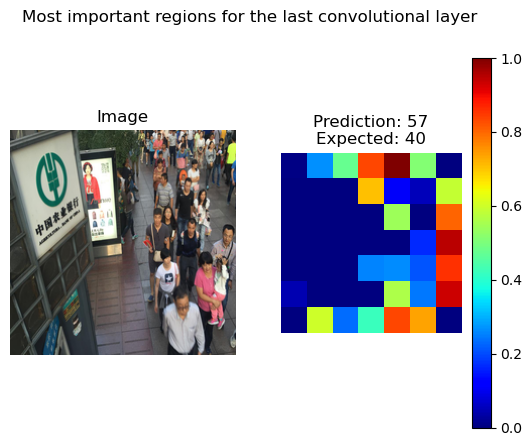

In [22]:
# Sample
image = X_test[20:21]

# Layer
last_conv_layer_name = 'top_activation'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = image[0] / 255
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[20]}")

plt.show()

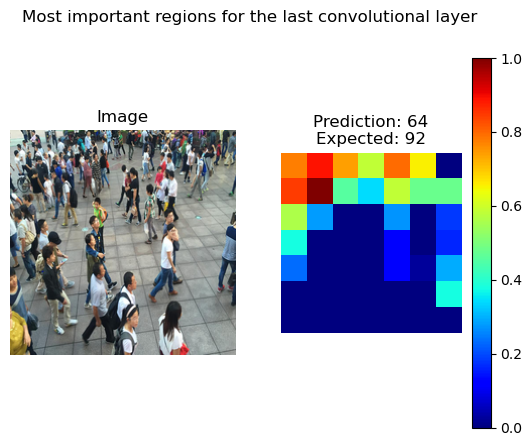

In [23]:
# Sample
image = X_test[211:212]

# Layer
last_conv_layer_name = 'top_activation'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = image[0] / 255
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[211]}")

plt.show()

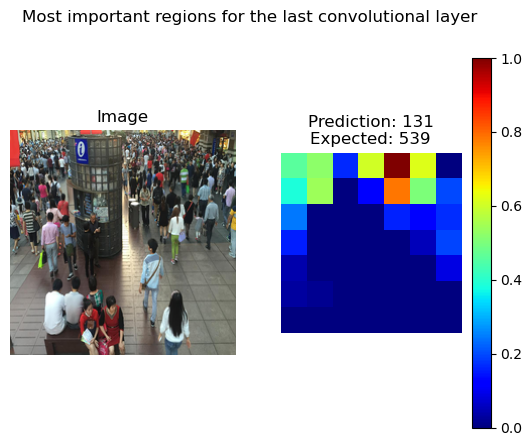

In [24]:
# Sample
image = X_test[289:290]

# Layer
last_conv_layer_name = 'top_activation'

# Grad-CAM model
last_conv_layer = model.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image)
    loss = predictions[:, 0]  # regression

# Gradients
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Heatmap normalization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Results
image_norm = image[0] / 255
plt.suptitle("Most important regions for the last convolutional layer")
plt.subplot(1, 2, 1)
plt.imshow(image_norm)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title(f"Prediction: {np.round(predictions.numpy()[0][0]).astype('int64')}"
          f"\nExpected: {y_test[289]}")

plt.show()

In [26]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 19.  23.]
 [109. 181.]
 [149. 157.]
 [ 59.  37.]
 [ 68.  70.]
 [ 32.  57.]
 [ 26.  44.]
 [195. 227.]
 [151. 165.]
 [253. 476.]
 [103. 139.]
 [197. 316.]
 [119. 164.]
 [119. 110.]
 [ 32.  20.]
 [119. 131.]
 [ 49.  48.]
 [143. 183.]
 [145. 101.]
 [186. 204.]
 [ 57.  40.]
 [106. 143.]
 [ 98. 146.]
 [263. 513.]
 [ 57.  70.]
 [ 90. 175.]
 [ 27.  51.]
 [ 84.  55.]
 [ 26.  67.]
 [ 57.  72.]
 [ 37.  56.]
 [107. 165.]
 [ 17.  32.]
 [ 93. 149.]
 [ 48.  48.]
 [ 84.  80.]
 [ 49. 117.]
 [ 79. 162.]
 [168. 137.]
 [141. 120.]
 [ 70.  72.]
 [101. 122.]
 [117. 198.]
 [ 81. 133.]
 [ 90. 147.]
 [ 20.  29.]
 [ 20.  70.]
 [ 23.  35.]
 [ 62.  24.]
 [187. 251.]
 [ 45.  59.]
 [ 67.  67.]
 [ 49.  61.]
 [154. 248.]
 [163. 252.]
 [162. 147.]
 [ 22.  57.]
 [ 92. 121.]
 [ 32.  47.]
 [244. 505.]
 [149. 297.]
 [246. 465.]
 [115. 167.]
 [ 55.  43.]
 [ 34.  46.]
 [ 89.  91.]
 [191. 263.]
 [ 91.  92.]
 [ 85. 117.]
 [ 43.  48.]
 [ 71.  54.]
 [ 73.  73.]
 [ 64. 122.]
 [ 67.  60.]
 [193. 170.]
 [ 85. 167.]
 [ 33.  57.]

## Metrics

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5444668531417847
MSE: 4122.642578125
MAE: 39.9208869934082
RMSE: 64.20780944824219
